<a href="https://colab.research.google.com/github/tanyavijj/edtech-project/blob/main/FINAL_CLEANED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NATURAL LANGUAGE IMAGE SEARCH USING A DUAL ENCODER

## Environment Setup

In [ ]:
from google.colab import drive
import os
import cv2
import tarfile
import torch
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set()

## Mount Google Drive and Set Paths

In [ ]:
drive.mount('/content/drive')
base_folder = "/content/drive/MyDrive/iit data/"
tar_file = os.path.join(base_folder, "YouTubeClips.tar")
annotation_file = os.path.join(base_folder, "annotations.txt")
frame_output_folder = os.path.join(base_folder, "frames")

Mounted at /content/drive


## Extract Video Files if Needed

In [ ]:
if not os.path.exists(frame_output_folder):
    os.makedirs(frame_output_folder, exist_ok=True)
    with tarfile.open(tar_file, "r") as tar:
        tar.extractall(path=frame_output_folder)
    print(f"Extracted TAR file to {frame_output_folder}")
else:
    print("Frames folder already exists.")

Frames folder already exists.


## Extract Frames from Videos

In [ ]:
def extract_frames(video_folder, output_folder, fps=1):
    os.makedirs(output_folder, exist_ok=True)
    for video_file in os.listdir(video_folder):
        if video_file.endswith((".mp4", ".avi")):
            cap = cv2.VideoCapture(os.path.join(video_folder, video_file))
            frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
            frame_id = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret: break
                if frame_id % frame_rate == 0:
                    fname = os.path.join(output_folder, f"{video_file.split('.')[0]}_frame_{frame_id}.jpg")
                    cv2.imwrite(fname, frame)
                frame_id += 1
            cap.release()
            print(f"Extracted: {video_file}")

## Verify Extraction

20929 frames found.


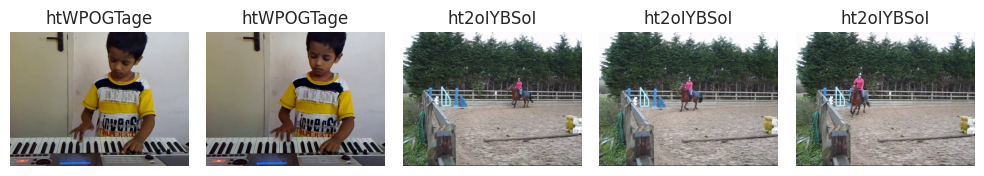

In [ ]:
extract_frames(frame_output_folder, frame_output_folder)
frames = os.listdir(frame_output_folder)
print(f"{len(frames)} frames found.")
plt.figure(figsize=(10,4))
for i, fname in enumerate(frames[:5]):
    img = Image.open(os.path.join(frame_output_folder, fname))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(fname[:10])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Create Caption Mapping from Annotations

In [ ]:
import os

def create_caption_mapping(annotation_file, frame_output_folder):
    # Step 1: Load all frame names once (FAST lookup with a dictionary)
    frame_dict = {os.path.splitext(frame)[0]: frame for frame in os.listdir(frame_output_folder)}
    captions = {}

    # Step 2: Process annotations
    with open(annotation_file, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                video_file = parts[0].strip()
                caption = parts[1].strip()
                frame_prefix = os.path.splitext(video_file)[0]

                # Instead of looping, just check if frame exists in dictionary
                if frame_prefix in frame_dict:
                    captions[frame_dict[frame_prefix]] = caption

    print(f"Captions mapped: {len(captions)} frames found.")
    return captions

# Run function
captions = create_caption_mapping("/content/drive/MyDrive/iit data/annotations.txt",
                                  "/content/drive/MyDrive/iit data/frames")

Captions mapped: 0 frames found.


## Load CLIP Model and Define Preprocessors

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return transform(img).unsqueeze(0)

def preprocess_text(text):
    return tokenizer(text, return_tensors="pt")["input_ids"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

## CLIP-Based Image Search

In [ ]:
def image_search(query, frame_folder=frame_output_folder, top_k=5):
    query_tokens = preprocess_text(query)
    text_features = model.get_text_features(input_ids=query_tokens)
    frame_scores = []
    for frame in tqdm(os.listdir(frame_folder)):
        if frame.endswith(".jpg"):
            img_path = os.path.join(frame_folder, frame)
            image_tensor = preprocess_image(img_path)
            image_features = model.get_image_features(pixel_values=image_tensor)
            similarity = torch.cosine_similarity(image_features, text_features)
            frame_scores.append((frame, similarity.item(), img_path))
    top_results = sorted(frame_scores, key=lambda x: x[1], reverse=True)[:top_k]
    print(f"Query: {query}")
    for frame, score, path in top_results:
        print(f"{frame}: {score:.4f}")
        display(Image.open(path))
    return top_results

## Run Search and Save Results

100%|██████████| 20929/20929 [4:08:39<00:00,  1.40it/s]

Query: A person playing guitar
vZa13vJugGU_0_30_frame_90.jpg: 0.3167


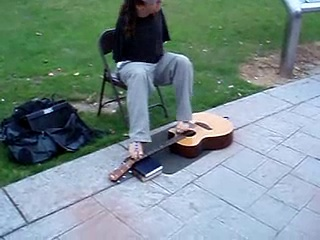

vZa13vJugGU_0_30_frame_0.jpg: 0.3153


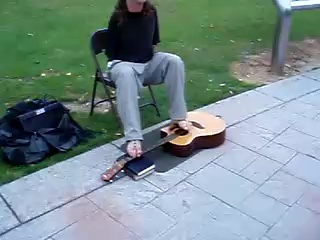

vZa13vJugGU_0_30_frame_300.jpg: 0.3153


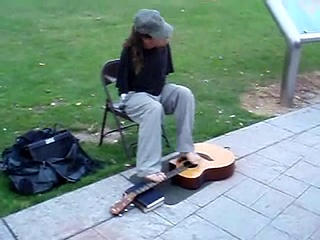

vZa13vJugGU_0_30_frame_135.jpg: 0.3150


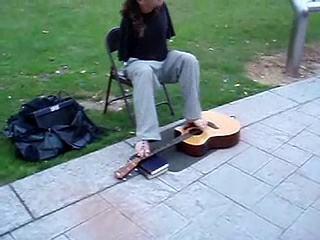

7_XASfcYdBk_3_13_frame_0.jpg: 0.3148


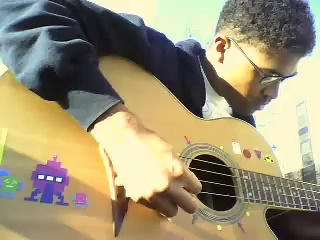

In [ ]:
query = "A person playing guitar"
results = image_search(query)
results_df = pd.DataFrame(results, columns=["Frame", "Similarity", "Path"])
results_df.to_csv(os.path.join(base_folder, "search_results.csv"), index=False)

## Evaluation: Score Distribution

<ipython-input-11-0f9940c98d25>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, len(similarities)+1)), y=similarities, palette="viridis")


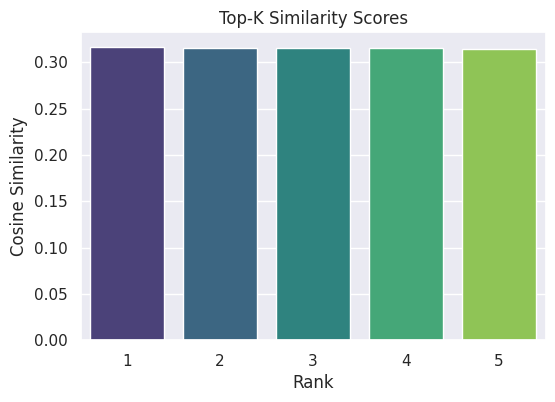

In [ ]:
similarities = [score for _, score, _ in results]
plt.figure(figsize=(6,4))
sns.barplot(x=list(range(1, len(similarities)+1)), y=similarities, palette="viridis")
plt.title("Top-K Similarity Scores")
plt.xlabel("Rank")
plt.ylabel("Cosine Similarity")
plt.show()

## Additional Search Queries

##  Visualize Similarities and Predictions

In [ ]:
def visualize_similarity_barplot(results, query):
    frames, scores = zip(*[(frame, score) for frame, score, _ in results])
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(frames), y=list(scores), palette="mako")
    plt.title(f"Similarity Scores for Top-K Results\nQuery: '{query}'")
    plt.xlabel("Frame")
    plt.ylabel("Cosine Similarity")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_results_with_captions(results, captions_dict=None):
    plt.figure(figsize=(15, 4))
    for i, (frame, score, path) in enumerate(results):
        img = Image.open(path)
        plt.subplot(1, len(results), i+1)
        plt.imshow(img)
        plt.title(f"{frame[:10]}\nSim: {score:.2f}", fontsize=8)
        if captions_dict and frame in captions_dict:
            plt.xlabel(captions_dict[frame][:30], fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
query = "A person playing guitar"
results = image_search(query)
visualize_similarity_barplot(results, query)
visualize_results_with_captions(results, captions)

  1%|          | 210/20929 [00:58<2:15:25,  2.55it/s]

In [ ]:
results_df.to_csv('/content/drive/MyDrive/iit data/search_results.csv', index=False)


In [ ]:
plt.savefig('/content/drive/MyDrive/iit data/similarity_plot.png')
